In [35]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
import datetime
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve,ShuffleSplit
import warnings
warnings.filterwarnings('ignore')

# 载入数据

In [36]:
train = pd.read_csv("./forestfires.csv")
train.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [37]:
train.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


- 由于rain数据25%,50%,75%的数据都为0，因此对其进行查看分析。

In [38]:
sum(train['rain'] == 0)/len(train)

0.9845261121856866

- rain数据的零占比为98%，考虑删除。
- 因为day数据为周，无实际意义，因此考虑删除。

In [39]:
train.drop(['rain','day'],axis=1,inplace=True)

In [40]:
train.shape

(517, 11)

In [41]:
train.isnull().sum()

X        0
Y        0
month    0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
area     0
dtype: int64

In [42]:
train['month']=train['month'].apply(lambda x:list(calendar.month_abbr).index(x.title()))

In [43]:
train.head()

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,area
0,7,5,3,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,10,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,10,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.0
4,8,6,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


# 目标变量分析

- 由于area的中位数是0.52，至少有一半的数据小于0.52，但均值却为12.85，因此可以大致判断area数据为右偏分布。

In [44]:
print("Skewness of area:%f" %train['area'].skew()) #偏态
print("Kurtosis of area:%f" %train['area'].kurt()) #峰态

Skewness of area:12.846934
Kurtosis of area:194.140721


- 变换后的数据更好的满足正态性的假设前提。很可能会对ML模型的学习带来更好的效果。

In [45]:
#Box-Cox转换
lambda_1=boxcox_normmax(train['area']+1)
train['area_boxcox']=boxcox1p(train['area'],lambda_1)

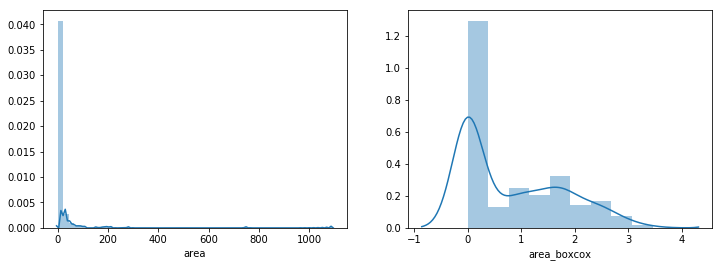

In [46]:
fig=plt.figure(figsize=(12,4))
plt.subplot(121)
sns.distplot(train['area'])
plt.subplot(122)
sns.distplot(train['area_boxcox'])
plt.show()

- 小组研究谈论，发现原因可能area为0的数据过多，造成数据噪声，精度失真。

In [47]:
sum(train['area'] == 0)/len(train)

0.47775628626692457

In [48]:
train_1 = train[train['area'] > 0]
train_0=train[train['area'] == 0].sample(n=30)
train = pd.concat([train_1,train_0],axis=0)
train.shape

(300, 12)

- 减少了217个数据

In [49]:
train.reset_index(inplace=True)

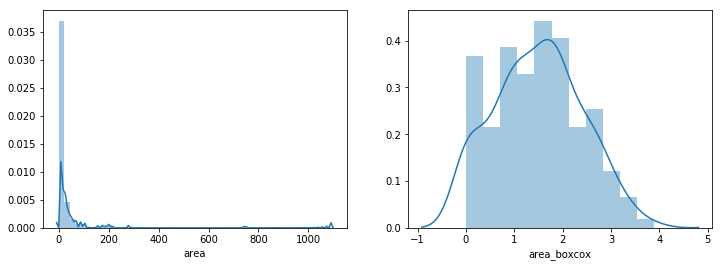

In [50]:
#Box-Cox转换
lambda_1=boxcox_normmax(train['area']+1)
train['area_boxcox']=boxcox1p(train['area'],lambda_1)
fig=plt.figure(figsize=(12,4))
plt.subplot(121)
sns.distplot(train['area'])
plt.subplot(122)
sns.distplot(train['area_boxcox'])
plt.show()

In [51]:
print("Skewness of area:%f" %train['area'].skew())
print("Kurtosis of area:%f" %train['area'].kurt())
print("*"*30)
print("Skewness of area_boxcox:%f" %train['area_boxcox'].skew())
print("Kurtosis of area_boxcox:%f" %train['area_boxcox'].kurt())

Skewness of area:9.918392
Kurtosis of area:114.684358
******************************
Skewness of area_boxcox:0.108407
Kurtosis of area_boxcox:-0.617567


# 数据探索性分析

- X,Y

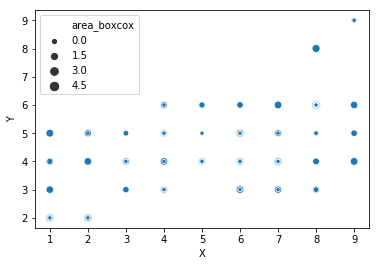

In [52]:
sns.scatterplot(x='X',y='Y',size='area_boxcox',data=train)
plt.show()

- month

In [53]:
#火灾发生的次数
train['area_count'] = train['area'].apply(lambda x:0 if x ==0.0 else 1)

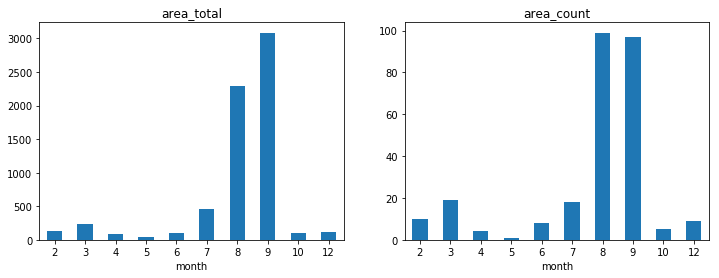

In [54]:
#各月份火灾烧伤的总面积
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
train.groupby(['month'])['area'].sum().plot(kind='bar',rot=0,title='area_total')
plt.subplot(122)
train.groupby(['month'])['area_count'].sum().plot(kind='bar',rot=0,title='area_count')
plt.show()

In [55]:
def month_(x):
    if x == 8 or x == 9:
        x = 1
    else:
        x=0
    return x

In [56]:
#按照火灾情况对月份分组
train['month_']=train['month'].apply(lambda x:month_(x))

In [57]:
train.head()

,index,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,area,area_boxcox,area_count,month_
0,138,9,9,7,85.8,48.3,313.4,3.9,18.0,42,2.7,0.36,0.298784,1,0
1,139,1,4,9,91.0,129.5,692.6,7.0,21.7,38,2.2,0.43,0.345939,1,1
2,140,2,5,9,90.9,126.5,686.5,7.0,21.9,39,1.8,0.47,0.371670,1,1
3,141,1,2,8,95.5,99.9,513.3,13.2,23.3,31,4.5,0.55,0.420723,1,1
4,142,8,6,8,90.1,108.0,529.8,12.5,21.2,51,8.9,0.61,0.455580,1,1


In [58]:
train.drop(['month','area','area_count'],axis=1,inplace=True)

# 数据预处理

- 数据归一化处理

In [59]:
train.head()

,index,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,area_boxcox,month_
0,138,9,9,85.8,48.3,313.4,3.9,18.0,42,2.7,0.298784,0
1,139,1,4,91.0,129.5,692.6,7.0,21.7,38,2.2,0.345939,1
2,140,2,5,90.9,126.5,686.5,7.0,21.9,39,1.8,0.371670,1
3,141,1,2,95.5,99.9,513.3,13.2,23.3,31,4.5,0.420723,1
4,142,8,6,90.1,108.0,529.8,12.5,21.2,51,8.9,0.455580,1


In [60]:
cols=train.columns[:-1]
for col in cols:
    train[col] = MinMaxScaler().fit_transform(train[col].values.reshape(-1,1)).reshape(1,-1)[0]

In [61]:
train.head()

,index,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,area_boxcox,month_
0,0.259843,1.000,1.000000,0.681957,0.157128,0.358274,0.141553,0.508039,0.333333,0.255556,0.076696,0
1,0.261811,0.000,0.285714,0.840979,0.438779,0.802979,0.283105,0.627010,0.283951,0.200000,0.088801,1
2,0.263780,0.125,0.428571,0.837920,0.428373,0.795825,0.283105,0.633441,0.296296,0.155556,0.095406,1
3,0.265748,0.000,0.000000,0.978593,0.336108,0.592706,0.566210,0.678457,0.197531,0.455556,0.107997,1
4,0.267717,0.875,0.571429,0.813456,0.364204,0.612056,0.534247,0.610932,0.444444,0.944444,0.116945,1


- 分类变量独热编码处理

In [62]:
#对month_独热编码
lb_encoder = LabelEncoder()
lb_tran_f = lb_encoder.fit_transform(train['month_'])
oht_encoder = OneHotEncoder(sparse=False).fit(lb_tran_f.reshape(-1,1))

In [63]:
oht_train=pd.DataFrame(oht_encoder.transform(lb_tran_f.reshape(-1,1)).astype(int))
train=pd.concat([train,oht_train], axis=1,)

In [64]:
train.head()

,index,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,area_boxcox,month_,0,1
0,0.259843,1.000,1.000000,0.681957,0.157128,0.358274,0.141553,0.508039,0.333333,0.255556,0.076696,0,1,0
1,0.261811,0.000,0.285714,0.840979,0.438779,0.802979,0.283105,0.627010,0.283951,0.200000,0.088801,1,0,1
2,0.263780,0.125,0.428571,0.837920,0.428373,0.795825,0.283105,0.633441,0.296296,0.155556,0.095406,1,0,1
3,0.265748,0.000,0.000000,0.978593,0.336108,0.592706,0.566210,0.678457,0.197531,0.455556,0.107997,1,0,1
4,0.267717,0.875,0.571429,0.813456,0.364204,0.612056,0.534247,0.610932,0.444444,0.944444,0.116945,1,0,1


In [65]:
train.describe()

,index,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,area_boxcox,month_,0,1
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.561457,0.478750,0.335714,0.839755,0.381718,0.651982,0.380350,0.548114,0.353210,0.410037,0.383577,0.720000,0.280000,0.720000
std,0.244980,0.297559,0.174133,0.117781,0.213911,0.275743,0.187998,0.193558,0.183862,0.205459,0.231330,0.449749,0.449749,0.449749
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.367618,0.250000,0.285714,0.819572,0.276188,0.552861,0.269406,0.446945,0.222222,0.255556,0.222472,0.000000,0.000000,0.000000
50%,0.530512,0.500000,0.285714,0.862385,0.375304,0.764747,0.347032,0.572347,0.320988,0.400000,0.396757,1.000000,0.000000,1.000000
75%,0.761319,0.750000,0.428571,0.899083,0.474592,0.829366,0.470320,0.679260,0.469136,0.500000,0.534889,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- 划分数据集

In [66]:
from sklearn.model_selection import train_test_split
Y = train['area_boxcox']
X = train.drop(['area_boxcox'],axis=1)
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=123)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((210, 13), (210,), (90, 13), (90,))

# SVR预测调参

- **SVR怎样能得到好的结果**
    - 1. 对数据做归一化
    - 2. 应用 RBF kernel
    - 3. 用cross-validation和grid-search 得到最优的c和g
    - 4. 用得到的最优c和g训练训练数据
    - 5. 测试

- **选择核函数**

In [67]:
svr = SVR()

In [68]:
names = ['linear', 'rbf','poly']
for name in names:
    svr = SVR(kernel=name)
    svr.fit(x_train,y_train)
    y_pred = svr.predict(x_test)
    print(name,mean_squared_error(y_test,y_pred))

linear 0.05488038691826269
rbf 0.0517083575357098
poly 0.052192650570372826


- **对rbf调参**
- gamma 
    - gamma越大，支持向量越少，gamma 越小，支持向量越多。而支持向量的个数影响训练和预测的速度。
    - gamma参数通常可选择下面几个数的倒数：0.1 0.2 0.4 0.6 0.8 1.6 3.2 6.4 12.8，默认的是类别数的倒数，即1/k，2分类的话就是0.5
- C 
    - C越高，容易过拟合。C 越小，容易欠拟合。
    - C一般可以选择为：10^t , t=[- 4，4]就是0.0001 到10000。
- **调参方法**
- Grid Search网格搜索，调参数
    - 可以得到全局最优
    - (C,gamma)相互独立，便于并行化进行

In [91]:
model = SVR(kernel='rbf') 
params = {'C': [1e-3, 1e-2, 1e-1,1, 10, 100, 1000],
                       'gamma': [1e-3, 1e-2, 1e-1,1, 10, 100, 1000]}
reg = GridSearchCV(model, params,cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
reg.fit(x_train,y_train)
print('best_params:{0}'.format(reg.best_params_))                                                                 
# print('best_score:{0}'.format(-reg.best_score_))  

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best_params:{'C': 0.1, 'gamma': 10}


[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    1.2s finished


In [93]:
svr = SVR(kernel='rbf',C=0.1,gamma=10)
svr.fit(x_train,y_train)
y_pred = svr.predict(x_test)
mean_squared_error(y_test,y_pred)

0.048125781619807115

- 绘制学习曲线

In [84]:
#观察模型的过拟合程度和拟合效果
def plot_learning_curve(estimator,title,X,y,ylim=None,cv=5,n_jobs=4,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("mean_squared_error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring="neg_mean_squared_error",
        n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [85]:
svr=SVR(C=0.1,gamma=10)

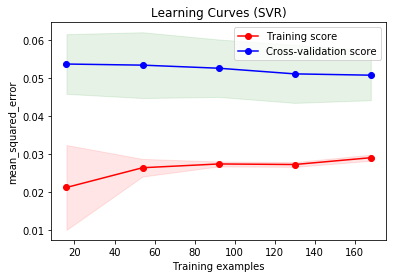

In [86]:
X, y = x_train, y_train
title = "Learning Curves (SVR)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = svr
plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=4)
plt.show()

- 出现过拟合的现象，可降低C的值。

- **不足之处**
    - 1.删除数据有关。一共517个数据，本次处理删除了将近一半的数据。删除的数据还是随机的，会对结果造成一定的影响。
    - 2.没有对特征进行筛选，特征过多的话，会对结果有一定的噪声影响。没有展示特征的重要性。可使用相关系数或者利用随机森林进行特征的选择和重要性评估。
    - 3.没有拆分训练集(训练数据)、验证集(调整参数)和测试集(衡量模型好坏)。这样会导致最终的评分结果比实际效果好。